# Homework #7: Boosting and Support Vector Machines

You're working for a car manufacturer that is looking to implement driver assistance features such as automated steering and adaptive cruise control. While technologically advanced, these systems still require driver attention. Some manufacturers simply require keeping your hands on the wheel but your company would also like to ensure the driver's focus remains on the road. To accomplish this, they'd like you to construct a model that can use the position of facial features to determine whether the driver is looking straight or not.

A separate system has been used to extract the eye, mouth, and nose positions from images taken of the driver, your goal is to use these features to predict the direction of the driver's gaze. The dataset listed below has been provided for these tasks.

### Relevant Dataset
`drivPoints.txt`

* Response Variable: `label`. Note: this includes looking left, right, and straight. We will convert this to a binary response.
* Predictor Variables:
    * [`xF` `yF` `wF` `hF`] = face position
    * [`xRE` `yRE`] = rigth eye position
    * [`xLE` `yL`] = left eye position
    * [`xN` `yN`] = Nose position
    * [`xRM` `yRM`] = rigth corner of mouth
    * [`xLM` `yLM`] = left corner of mouth
    
### Source
https://archive.ics.uci.edu/ml/datasets/DrivFace

## Task 1: Import the dataset and create a binary variable of `lookingStraight`. Split into train/test set.
This variable should take the value of `1` when `label=2` and `0` everywhere else. There should be a large class imbalance between looking straight or not (which you would expect given the people are driving).

In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_blobs, make_circles, make_classification, fetch_olivetti_faces
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc, classification_report
from statistics import mode
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import time
from collections import Counter
from sklearn import model_selection, naive_bayes, svm
from sklearn.svm import SVC

%matplotlib inline

In [2]:
df = pd.read_csv('drivPoints.txt')
df.head()

,fileName,subject,imgNum,label,ang,xF,yF,wF,hF,xRE,yRE,xLE,yLE,xN,yN,xRM,yRM,xLM,yLM
0,20130529_01_Driv_001_f,1,1,2,0,292,209,100,112,323,232,367,231,353,254,332,278,361,278
1,20130529_01_Driv_002_f,1,2,2,0,286,200,109,128,324,235,366,235,353,258,333,281,361,281
2,20130529_01_Driv_003_f,1,3,2,0,290,204,105,121,325,240,367,239,351,260,334,282,362,282
3,20130529_01_Driv_004_f,1,4,2,0,287,202,112,118,325,230,369,230,353,253,335,274,362,275
4,20130529_01_Driv_005_f,1,5,2,0,290,193,104,119,325,224,366,225,353,244,333,268,363,268


In [3]:
df['lookingStraight'] = np.where(df['label']==2,1,0)

In [4]:
df.drop(['fileName','subject','imgNum','label','ang'], axis=1, inplace=True)
df.head()

,xF,yF,wF,hF,xRE,yRE,xLE,yLE,xN,yN,xRM,yRM,xLM,yLM,lookingStraight
0,292,209,100,112,323,232,367,231,353,254,332,278,361,278,1
1,286,200,109,128,324,235,366,235,353,258,333,281,361,281,1
2,290,204,105,121,325,240,367,239,351,260,334,282,362,282,1
3,287,202,112,118,325,230,369,230,353,253,335,274,362,275,1
4,290,193,104,119,325,224,366,225,353,244,333,268,363,268,1


In [5]:
X = df.drop(['lookingStraight'],axis=1)
y = df['lookingStraight']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 31)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(484, 14) (122, 14)
(484,) (122,)


In [6]:
df['lookingStraight'].mean()

0.900990099009901

## Task 2: Perform a cross-validated (or use a single validation set) grid search of the hyperparameters for the `GradientBoostingClassifier` to find the best model.
You should at least tune the learning rate and number of trees in the model but feel free to go as deep as you'd like on this analysis).

In [7]:
cvtrain = pd.concat([X_train, y_train], axis=1)
folds = np.random.choice(a = 10, size = cvtrain.shape[0])

acc_list = []
for i in range(10):
    val = cvtrain.iloc[np.where(folds == i)[0],:]
    train = cvtrain.iloc[np.where(folds != i)[0],:]

    Xval = val.drop(['lookingStraight'],axis=1)
    Xtrain = train.drop(['lookingStraight'],axis=1)
    yval = val['lookingStraight']
    ytrain = train['lookingStraight']
    
    boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                       max_depth=1, random_state=0).fit(Xtrain, ytrain)
    
    val_acc = boost.score(Xval, yval)
    acc_list.append(val_acc)
    print(f'Validation accuracy: {val_acc}')

Validation accuracy: 0.9302325581395349
Validation accuracy: 0.9361702127659575
Validation accuracy: 0.9107142857142857
Validation accuracy: 1.0
Validation accuracy: 0.9761904761904762
Validation accuracy: 0.9183673469387755
Validation accuracy: 0.8979591836734694
Validation accuracy: 0.7884615384615384
Validation accuracy: 0.8947368421052632
Validation accuracy: 0.9318181818181818


In [8]:
np.mean(acc_list)

0.9184650625807482

In [9]:
# first search was 1-41 trees, depth 1-5, and learning rates .1 - 1.1
# after this analysis, I extended the ranges to ensure that the true ideal values are found

num_trees = np.arange(41, 101, 10)
learning_rates = np.linspace(0.00001,.4,5)
depths = np.arange(3, 7, 1)
val_acc_list = []
hyperparameter_combo = []

for n in num_trees:
    for lr in learning_rates:
        for d in depths:
            acc_list = []
            for i in range(10):
                val = cvtrain.iloc[np.where(folds == i)[0],:]
                train = cvtrain.iloc[np.where(folds != i)[0],:]

                Xval = val.drop(['lookingStraight'],axis=1)
                Xtrain = train.drop(['lookingStraight'],axis=1)
                yval = val['lookingStraight']
                ytrain = train['lookingStraight']

                boost = GradientBoostingClassifier(n_estimators=n, learning_rate=lr,
                                                   max_depth=d, random_state=0).fit(Xtrain, ytrain)

                val_acc = boost.score(Xval, yval)
                acc_list.append(val_acc)
                print(f'Completed tree {n} and learning rate of {lr} and depth of {d}')
            val_acc_list.append(np.mean(acc_list))
            hyperparameter_combo.append((n,lr,d))

Completed tree 41 and learning rate of 1e-05 and depth of 3
Completed tree 41 and learning rate of 1e-05 and depth of 3
Completed tree 41 and learning rate of 1e-05 and depth of 3
Completed tree 41 and learning rate of 1e-05 and depth of 3
Completed tree 41 and learning rate of 1e-05 and depth of 3
Completed tree 41 and learning rate of 1e-05 and depth of 3
Completed tree 41 and learning rate of 1e-05 and depth of 3
Completed tree 41 and learning rate of 1e-05 and depth of 3
Completed tree 41 and learning rate of 1e-05 and depth of 3
Completed tree 41 and learning rate of 1e-05 and depth of 3
Completed tree 41 and learning rate of 1e-05 and depth of 4
Completed tree 41 and learning rate of 1e-05 and depth of 4
Completed tree 41 and learning rate of 1e-05 and depth of 4
Completed tree 41 and learning rate of 1e-05 and depth of 4
Completed tree 41 and learning rate of 1e-05 and depth of 4
Completed tree 41 and learning rate of 1e-05 and depth of 4
Completed tree 41 and learning rate of 1

Completed tree 41 and learning rate of 0.3000025 and depth of 3
Completed tree 41 and learning rate of 0.3000025 and depth of 3
Completed tree 41 and learning rate of 0.3000025 and depth of 3
Completed tree 41 and learning rate of 0.3000025 and depth of 3
Completed tree 41 and learning rate of 0.3000025 and depth of 3
Completed tree 41 and learning rate of 0.3000025 and depth of 4
Completed tree 41 and learning rate of 0.3000025 and depth of 4
Completed tree 41 and learning rate of 0.3000025 and depth of 4
Completed tree 41 and learning rate of 0.3000025 and depth of 4
Completed tree 41 and learning rate of 0.3000025 and depth of 4
Completed tree 41 and learning rate of 0.3000025 and depth of 4
Completed tree 41 and learning rate of 0.3000025 and depth of 4
Completed tree 41 and learning rate of 0.3000025 and depth of 4
Completed tree 41 and learning rate of 0.3000025 and depth of 4
Completed tree 41 and learning rate of 0.3000025 and depth of 4
Completed tree 41 and learning rate of 0

Completed tree 51 and learning rate of 0.1000075 and depth of 5
Completed tree 51 and learning rate of 0.1000075 and depth of 5
Completed tree 51 and learning rate of 0.1000075 and depth of 5
Completed tree 51 and learning rate of 0.1000075 and depth of 5
Completed tree 51 and learning rate of 0.1000075 and depth of 5
Completed tree 51 and learning rate of 0.1000075 and depth of 5
Completed tree 51 and learning rate of 0.1000075 and depth of 5
Completed tree 51 and learning rate of 0.1000075 and depth of 5
Completed tree 51 and learning rate of 0.1000075 and depth of 5
Completed tree 51 and learning rate of 0.1000075 and depth of 6
Completed tree 51 and learning rate of 0.1000075 and depth of 6
Completed tree 51 and learning rate of 0.1000075 and depth of 6
Completed tree 51 and learning rate of 0.1000075 and depth of 6
Completed tree 51 and learning rate of 0.1000075 and depth of 6
Completed tree 51 and learning rate of 0.1000075 and depth of 6
Completed tree 51 and learning rate of 0

Completed tree 51 and learning rate of 0.4 and depth of 5
Completed tree 51 and learning rate of 0.4 and depth of 5
Completed tree 51 and learning rate of 0.4 and depth of 5
Completed tree 51 and learning rate of 0.4 and depth of 6
Completed tree 51 and learning rate of 0.4 and depth of 6
Completed tree 51 and learning rate of 0.4 and depth of 6
Completed tree 51 and learning rate of 0.4 and depth of 6
Completed tree 51 and learning rate of 0.4 and depth of 6
Completed tree 51 and learning rate of 0.4 and depth of 6
Completed tree 51 and learning rate of 0.4 and depth of 6
Completed tree 51 and learning rate of 0.4 and depth of 6
Completed tree 51 and learning rate of 0.4 and depth of 6
Completed tree 51 and learning rate of 0.4 and depth of 6
Completed tree 61 and learning rate of 1e-05 and depth of 3
Completed tree 61 and learning rate of 1e-05 and depth of 3
Completed tree 61 and learning rate of 1e-05 and depth of 3
Completed tree 61 and learning rate of 1e-05 and depth of 3
Comple

Completed tree 61 and learning rate of 0.20000500000000002 and depth of 6
Completed tree 61 and learning rate of 0.20000500000000002 and depth of 6
Completed tree 61 and learning rate of 0.20000500000000002 and depth of 6
Completed tree 61 and learning rate of 0.20000500000000002 and depth of 6
Completed tree 61 and learning rate of 0.20000500000000002 and depth of 6
Completed tree 61 and learning rate of 0.20000500000000002 and depth of 6
Completed tree 61 and learning rate of 0.3000025 and depth of 3
Completed tree 61 and learning rate of 0.3000025 and depth of 3
Completed tree 61 and learning rate of 0.3000025 and depth of 3
Completed tree 61 and learning rate of 0.3000025 and depth of 3
Completed tree 61 and learning rate of 0.3000025 and depth of 3
Completed tree 61 and learning rate of 0.3000025 and depth of 3
Completed tree 61 and learning rate of 0.3000025 and depth of 3
Completed tree 61 and learning rate of 0.3000025 and depth of 3
Completed tree 61 and learning rate of 0.300

Completed tree 71 and learning rate of 0.1000075 and depth of 3
Completed tree 71 and learning rate of 0.1000075 and depth of 3
Completed tree 71 and learning rate of 0.1000075 and depth of 4
Completed tree 71 and learning rate of 0.1000075 and depth of 4
Completed tree 71 and learning rate of 0.1000075 and depth of 4
Completed tree 71 and learning rate of 0.1000075 and depth of 4
Completed tree 71 and learning rate of 0.1000075 and depth of 4
Completed tree 71 and learning rate of 0.1000075 and depth of 4
Completed tree 71 and learning rate of 0.1000075 and depth of 4
Completed tree 71 and learning rate of 0.1000075 and depth of 4
Completed tree 71 and learning rate of 0.1000075 and depth of 4
Completed tree 71 and learning rate of 0.1000075 and depth of 4
Completed tree 71 and learning rate of 0.1000075 and depth of 5
Completed tree 71 and learning rate of 0.1000075 and depth of 5
Completed tree 71 and learning rate of 0.1000075 and depth of 5
Completed tree 71 and learning rate of 0

Completed tree 71 and learning rate of 0.4 and depth of 4
Completed tree 71 and learning rate of 0.4 and depth of 4
Completed tree 71 and learning rate of 0.4 and depth of 4
Completed tree 71 and learning rate of 0.4 and depth of 4
Completed tree 71 and learning rate of 0.4 and depth of 4
Completed tree 71 and learning rate of 0.4 and depth of 4
Completed tree 71 and learning rate of 0.4 and depth of 4
Completed tree 71 and learning rate of 0.4 and depth of 4
Completed tree 71 and learning rate of 0.4 and depth of 5
Completed tree 71 and learning rate of 0.4 and depth of 5
Completed tree 71 and learning rate of 0.4 and depth of 5
Completed tree 71 and learning rate of 0.4 and depth of 5
Completed tree 71 and learning rate of 0.4 and depth of 5
Completed tree 71 and learning rate of 0.4 and depth of 5
Completed tree 71 and learning rate of 0.4 and depth of 5
Completed tree 71 and learning rate of 0.4 and depth of 5
Completed tree 71 and learning rate of 0.4 and depth of 5
Completed tree

Completed tree 81 and learning rate of 0.20000500000000002 and depth of 5
Completed tree 81 and learning rate of 0.20000500000000002 and depth of 5
Completed tree 81 and learning rate of 0.20000500000000002 and depth of 5
Completed tree 81 and learning rate of 0.20000500000000002 and depth of 5
Completed tree 81 and learning rate of 0.20000500000000002 and depth of 5
Completed tree 81 and learning rate of 0.20000500000000002 and depth of 5
Completed tree 81 and learning rate of 0.20000500000000002 and depth of 5
Completed tree 81 and learning rate of 0.20000500000000002 and depth of 5
Completed tree 81 and learning rate of 0.20000500000000002 and depth of 6
Completed tree 81 and learning rate of 0.20000500000000002 and depth of 6
Completed tree 81 and learning rate of 0.20000500000000002 and depth of 6
Completed tree 81 and learning rate of 0.20000500000000002 and depth of 6
Completed tree 81 and learning rate of 0.20000500000000002 and depth of 6
Completed tree 81 and learning rate of

Completed tree 91 and learning rate of 1e-05 and depth of 6
Completed tree 91 and learning rate of 1e-05 and depth of 6
Completed tree 91 and learning rate of 1e-05 and depth of 6
Completed tree 91 and learning rate of 1e-05 and depth of 6
Completed tree 91 and learning rate of 1e-05 and depth of 6
Completed tree 91 and learning rate of 1e-05 and depth of 6
Completed tree 91 and learning rate of 0.1000075 and depth of 3
Completed tree 91 and learning rate of 0.1000075 and depth of 3
Completed tree 91 and learning rate of 0.1000075 and depth of 3
Completed tree 91 and learning rate of 0.1000075 and depth of 3
Completed tree 91 and learning rate of 0.1000075 and depth of 3
Completed tree 91 and learning rate of 0.1000075 and depth of 3
Completed tree 91 and learning rate of 0.1000075 and depth of 3
Completed tree 91 and learning rate of 0.1000075 and depth of 3
Completed tree 91 and learning rate of 0.1000075 and depth of 3
Completed tree 91 and learning rate of 0.1000075 and depth of 3


Completed tree 91 and learning rate of 0.3000025 and depth of 6
Completed tree 91 and learning rate of 0.3000025 and depth of 6
Completed tree 91 and learning rate of 0.3000025 and depth of 6
Completed tree 91 and learning rate of 0.4 and depth of 3
Completed tree 91 and learning rate of 0.4 and depth of 3
Completed tree 91 and learning rate of 0.4 and depth of 3
Completed tree 91 and learning rate of 0.4 and depth of 3
Completed tree 91 and learning rate of 0.4 and depth of 3
Completed tree 91 and learning rate of 0.4 and depth of 3
Completed tree 91 and learning rate of 0.4 and depth of 3
Completed tree 91 and learning rate of 0.4 and depth of 3
Completed tree 91 and learning rate of 0.4 and depth of 3
Completed tree 91 and learning rate of 0.4 and depth of 3
Completed tree 91 and learning rate of 0.4 and depth of 4
Completed tree 91 and learning rate of 0.4 and depth of 4
Completed tree 91 and learning rate of 0.4 and depth of 4
Completed tree 91 and learning rate of 0.4 and depth o

Text(0.5, 0, 'Max Depth')

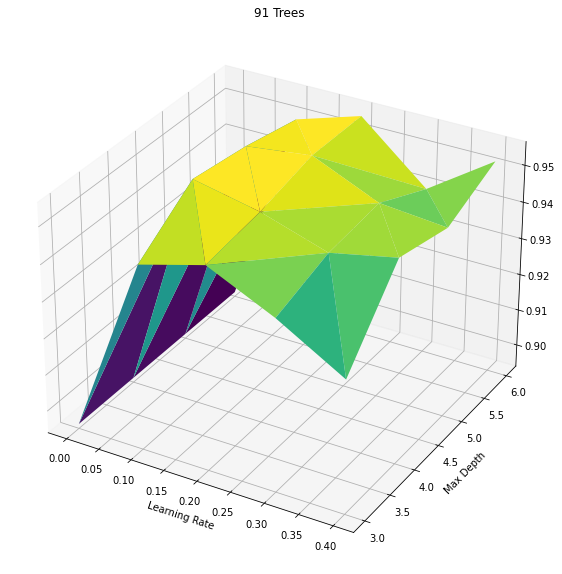

In [10]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][:20],
             list(zip(*hyperparameter_combo))[2][:20],
             val_acc_list[:20], cmap='viridis')
ax.set_title("%d Trees" % (n))
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')

0 20
20 40
40 60
60 80
80 100
100 120


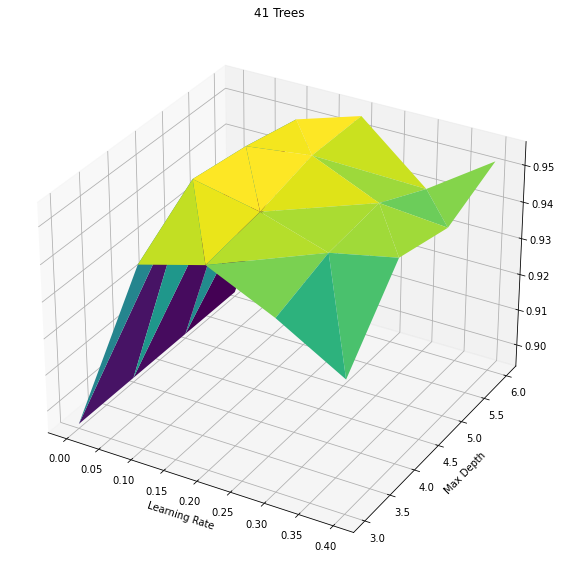

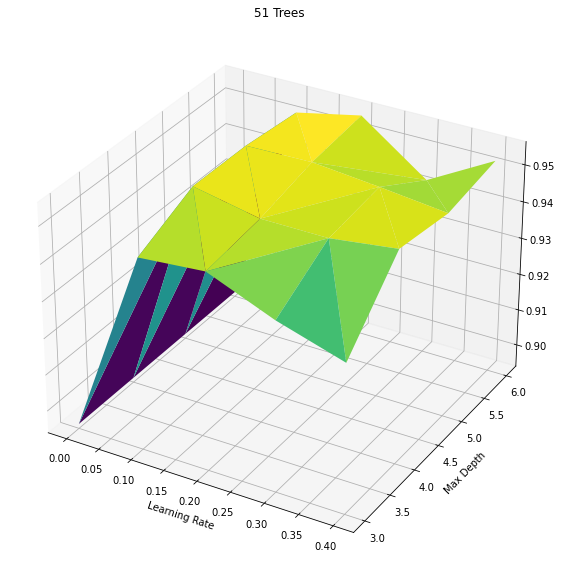

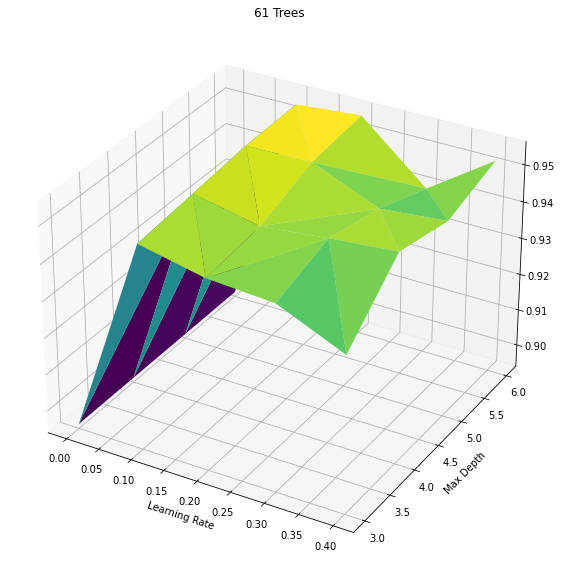

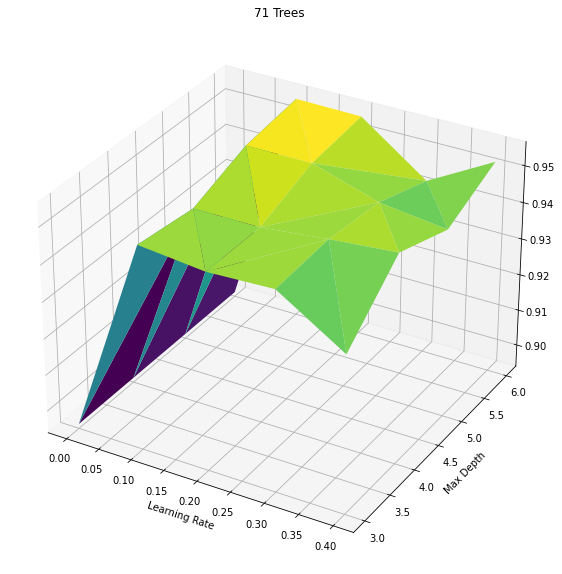

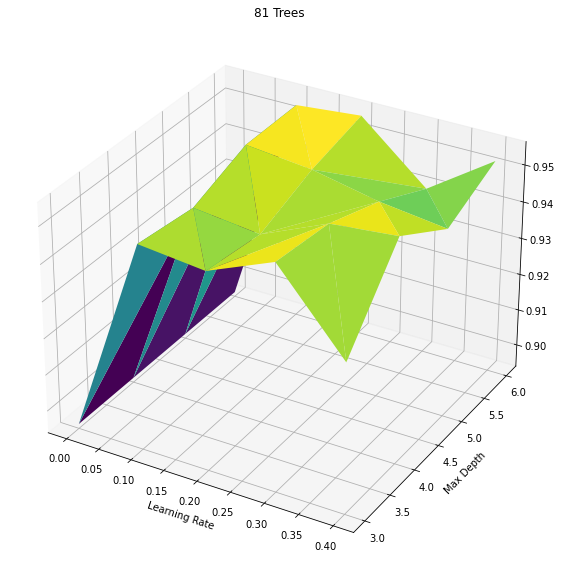

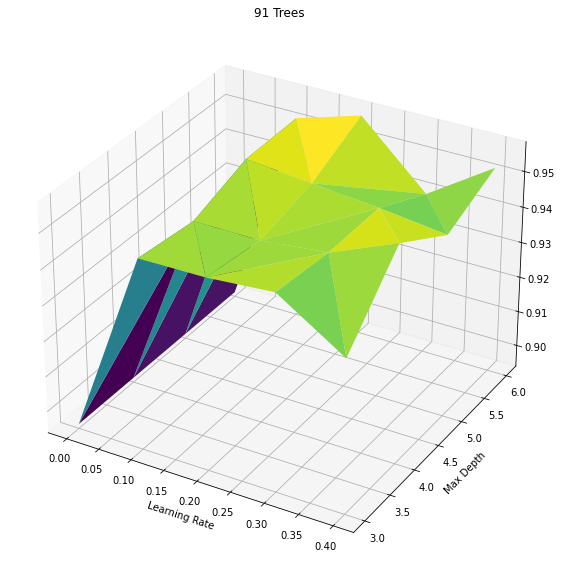

In [11]:
low_index = 1
high_index = 0
for n in range(41, 101, 10):
    low_index = high_index
    high_index = low_index + 20
    print(low_index,high_index)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][low_index:high_index],
                 list(zip(*hyperparameter_combo))[2][low_index:high_index],
                 val_acc_list[low_index:high_index], cmap='viridis')
    ax.set_title("%d Trees" % (n))
    plt.xlabel('Learning Rate')
    plt.ylabel('Max Depth')

In [12]:
hyperparameter_combo[np.argmax(val_acc_list)]

(91, 0.20000500000000002, 6)

In [13]:
hyperparameter_combos = []
for i in range(len(val_acc_list)):
    hyperparameter_combos.append([hyperparameter_combo[i], val_acc_list[i]])
    
hyperparameter_combos

[[(41, 1e-05, 3), 0.8951499897511976],
 [(41, 1e-05, 4), 0.8951499897511976],
 [(41, 1e-05, 5), 0.8951499897511976],
 [(41, 1e-05, 6), 0.8951499897511976],
 [(41, 0.1000075, 3), 0.9441332480453664],
 [(41, 0.1000075, 4), 0.9551105539474843],
 [(41, 0.1000075, 5), 0.9528883317252621],
 [(41, 0.1000075, 6), 0.9494855941119982],
 [(41, 0.20000500000000002, 3), 0.9491413038992869],
 [(41, 0.20000500000000002, 4), 0.9513821395047841],
 [(41, 0.20000500000000002, 5), 0.9551105539474843],
 [(41, 0.20000500000000002, 6), 0.9549731913101216],
 [(41, 0.3000025, 3), 0.9406988837463404],
 [(41, 0.3000025, 4), 0.9456521552033712],
 [(41, 0.3000025, 5), 0.9472564635933939],
 [(41, 0.3000025, 6), 0.939796513351489],
 [(41, 0.4, 3), 0.9301763319455931],
 [(41, 0.4, 4), 0.949464305585289],
 [(41, 0.4, 5), 0.9456325319694623],
 [(41, 0.4, 6), 0.9520789924856903],
 [(51, 1e-05, 3), 0.8951499897511976],
 [(51, 1e-05, 4), 0.8951499897511976],
 [(51, 1e-05, 5), 0.8951499897511976],
 [(51, 1e-05, 6), 0.89514

In [34]:
# Despite the argmax showing the ideal hyperparameters to be n=51, lr=.2, and d=6,
# the plot shows more stability in the hyperparameters at n=51, lr=.2, and d=4

boost = GradientBoostingClassifier(n_estimators=51, learning_rate=.2,
                                   max_depth=4, random_state=10).fit(Xtrain, ytrain)

test_acc = boost.score(X_test, y_test)
test_acc

0.9672131147540983

In [35]:
print(classification_report(y_test,boost.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.97      0.99      0.98       114

    accuracy                           0.97       122
   macro avg       0.90      0.81      0.85       122
weighted avg       0.96      0.97      0.97       122



## Task 3: Perform a cross-validated (or use a single validation set) grid search of the hyperparameters for the `SVC` (Support Vector Classifier) to find the best model.
You should at least tune `C` and the `kernel` but feel free to go as deep as you'd like on this analysis).

In [16]:
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, test_size=.2, random_state=41)

Naive = naive_bayes.MultinomialNB()
Naive.fit(Xtrain,ytrain)
predictions_NB = Naive.predict(Xval)
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, yval)*100)

Naive Bayes Accuracy Score ->  65.97938144329896


In [17]:
svc = SVC(C=0.01, kernel='linear')
cross_val_score(svc, Xtrain, ytrain, cv=10)

array([0.92307692, 0.92307692, 0.92307692, 0.92307692, 0.97435897,
       0.92307692, 0.94871795, 0.94736842, 0.89473684, 0.92105263])

In [18]:
params_grid = [{'kernel': ['rbf'],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [19]:
svm_model = GridSearchCV(SVC(), params_grid, cv=5, n_jobs=-1, verbose=4)
svm_model.fit(Xtrain, ytrain)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             verbose=4)

In [20]:
svm_model.cv_results_

{'mean_fit_time': array([1.00759029e-02, 1.04991436e-02, 1.32281303e-02, 1.43111229e-02,
        3.37778473e-01, 2.43323035e+00, 2.14735567e+01, 1.96564990e+02]),
 'std_fit_time': array([1.31710113e-03, 1.96926237e-03, 2.30361289e-03, 5.68578142e-03,
        1.94603994e-01, 1.53238933e+00, 1.43842026e+01, 1.15083408e+02]),
 'mean_score_time': array([0.00502791, 0.00723138, 0.00562634, 0.0055377 , 0.00486298,
        0.        , 0.00498552, 0.00159993]),
 'std_score_time': array([0.00259966, 0.0014478 , 0.00450712, 0.00436115, 0.00397067,
        0.        , 0.0040745 , 0.00319986]),
 'param_C': masked_array(data=[1, 10, 100, 1000, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'rbf', 'rbf', 'rbf', 'linear', 'linear',
                    'linear', 'linear'],
              mask=[False, False, False, False, False, False, False, False],
        fil

In [21]:
print('Best score for training data:', svm_model.best_score_)

Best score for training data: 0.9819180819180818


In [22]:
print('Best C:',svm_model.best_estimator_.C) 
print('Best Kernel:',svm_model.best_estimator_.kernel)
print('Best Gamma:',svm_model.best_estimator_.gamma)

Best C: 1000
Best Kernel: rbf
Best Gamma: scale


In [23]:
final_model = svm_model.best_estimator_
pred = final_model.predict(X_test)
pred_label = list(pred)
pred_label

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [24]:
print(confusion_matrix(y_test,pred))

[[  3   5]
 [  1 113]]


In [25]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.96      0.99      0.97       114

    accuracy                           0.95       122
   macro avg       0.85      0.68      0.74       122
weighted avg       0.94      0.95      0.94       122



## Questions
1. Is accuracy the best metric to use in these tasks or would there have been a better one? Explain.

2. Which model gave the "best" result using the metric you chose above?

3. (Bonus) Any other interesting insights from this model or data?

1. Accuracy is not the bese measurement to use because there is a class distribution difference. It would likely be best to use recall, because the cost of predicting that they are looking at the road when they aren't is greater than the cost of predicting they aren't looking at the road when they are.

2. The gradient boosting model performed better on recall.

3. The model is not actually very accurate at defining who is not looking. 